In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa

/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [3]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [4]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [5]:
PRE_TRAINED_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"

# Load Data

In [6]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [7]:

test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))

In [8]:

def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            timestamped_phonemes.append((timit2ipa(phoneme, "eng"), int(start), int(end)))
    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}
    

In [9]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [10]:

parsed_0 = timit_file_to_dict(test_files[0])
print(parsed_0)

{'timestamped_phonemes': [('', 0, 3400), ('', 3400, 4093), ('oʊ', 4093, 5000), ('n', 5000, 5300), ('t', 5300, 5600), ('tʃ', 5600, 6920), ('ɦ', 6920, 7720), ('h', 7720, 8563), ('eɪ', 8563, 10280), ('t', 10280, 11160), ('m', 11160, 11655), ('i', 11655, 12741), ('ɛ', 12741, 13720), ('n', 13720, 14360), ('i', 14360, 14872), ('m', 14872, 16280), ('ɔ', 16280, 17506), ('ɹ', 17506, 18120), ('', 18120, 25360)], 'wav_filename': 'data/TRAIN/DR7/MDLM0/SI1864.WAV'}


In [11]:
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

In [13]:
test_df = files_to_df(test_files)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðoʊzmjʉzɪʃɪnzhɑmənaɪzmɑvl̩ ləslɨ,"[0, 2353, 2720, 5800, 7101, 7800, 8240, 9176, ...","[2353, 2720, 5800, 7101, 7800, 8240, 9176, 110..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",æɾəstɹɑfɨkɛkɨnɑmɨkʌtæksnəglɛktðpɔɚ,"[0, 2170, 3080, 4600, 5000, 5940, 7560, 7940, ...","[2170, 3080, 4600, 5000, 5940, 7560, 7940, 858..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɨsaʊndɨvddʒɛnʌfɚzbjʉgl̩ skɛɹdðiæɾ̃əloʊp,"[0, 2122, 2850, 3309, 5296, 8560, 9508, 9829, ...","[2122, 2850, 3309, 5296, 8560, 9508, 9829, 997..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊntæsmitəkɛɹiənɔliɹæglaɪkðæt,"[0, 2040, 2520, 5096, 5221, 5973, 9000, 10200,...","[2040, 2520, 5096, 5221, 5973, 9000, 10200, 11..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔʌttʃoʊzənfjʉwl̩ bɨkʌmddʒɛnɚl̩ s,"[0, 2580, 2920, 3952, 4830, 6780, 9460, 10640,...","[2580, 2920, 3952, 4830, 6780, 9460, 10640, 11..."


### Cleaning Up Audio

In [14]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

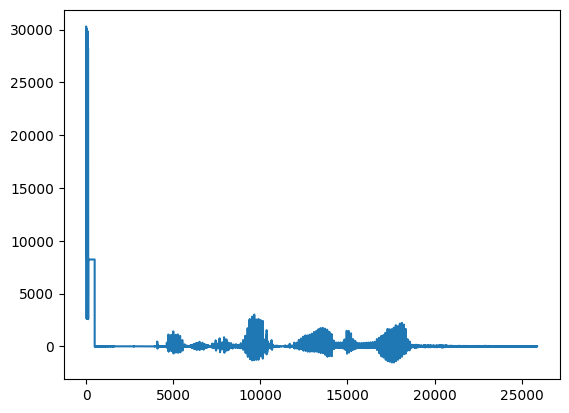

In [15]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(test_df['audio'][0])
plt.show()

In [17]:
test_df['cropped_audio'] = test_df.apply(crop_audio, axis=1)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðoʊzmjʉzɪʃɪnzhɑmənaɪzmɑvl̩ ləslɨ,"[0, 2353, 2720, 5800, 7101, 7800, 8240, 9176, ...","[2353, 2720, 5800, 7101, 7800, 8240, 9176, 110...","[-5, -2, -6, 0, -7, -4, -3, -6, -6, -5, -2, -6..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",æɾəstɹɑfɨkɛkɨnɑmɨkʌtæksnəglɛktðpɔɚ,"[0, 2170, 3080, 4600, 5000, 5940, 7560, 7940, ...","[2170, 3080, 4600, 5000, 5940, 7560, 7940, 858...","[2, 0, 0, 2, 0, 0, 5, 0, 3, 0, 0, 2, 1, 3, 0, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðɨsaʊndɨvddʒɛnʌfɚzbjʉgl̩ skɛɹdðiæɾ̃əloʊp,"[0, 2122, 2850, 3309, 5296, 8560, 9508, 9829, ...","[2122, 2850, 3309, 5296, 8560, 9508, 9829, 997...","[2, 1, 1, 0, 1, 0, 3, 2, 3, -1, 0, -1, 0, 0, 0..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊntæsmitəkɛɹiənɔliɹæglaɪkðæt,"[0, 2040, 2520, 5096, 5221, 5973, 9000, 10200,...","[2040, 2520, 5096, 5221, 5973, 9000, 10200, 11...","[0, -1, -1, 2, 1, 2, 4, 0, 2, 0, -1, 0, 0, 0, ..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔʌttʃoʊzənfjʉwl̩ bɨkʌmddʒɛnɚl̩ s,"[0, 2580, 2920, 3952, 4830, 6780, 9460, 10640,...","[2580, 2920, 3952, 4830, 6780, 9460, 10640, 11...","[2, 2, 6, 0, 3, 5, 4, 0, 1, 2, 1, 2, 1, 2, 1, ..."


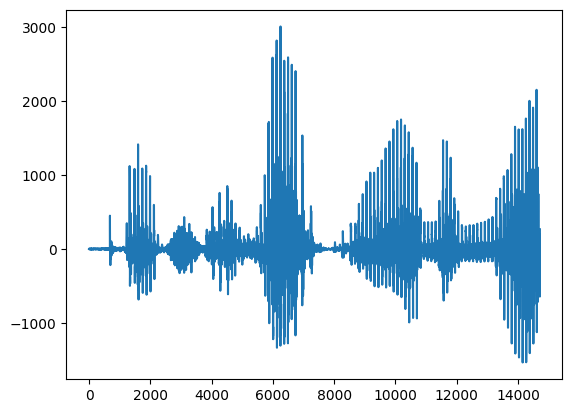

In [18]:
# visualize again, much better!
plt.plot(test_df['cropped_audio'][0])


In [20]:
# Same for test_df
test_df = test_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
test_df = test_df.rename(columns={'cropped_audio': 'audio'})
test_df.head()

,ipa,audio
0,ðoʊzmjʉzɪʃɪnzhɑmənaɪzmɑvl̩ ləslɨ,"[-5, -2, -6, 0, -7, -4, -3, -6, -6, -5, -2, -6..."
1,æɾəstɹɑfɨkɛkɨnɑmɨkʌtæksnəglɛktðpɔɚ,"[2, 0, 0, 2, 0, 0, 5, 0, 3, 0, 0, 2, 1, 3, 0, ..."
2,ðɨsaʊndɨvddʒɛnʌfɚzbjʉgl̩ skɛɹdðiæɾ̃əloʊp,"[2, 1, 1, 0, 1, 0, 3, 2, 3, -1, 0, -1, 0, 0, 0..."
3,oʊntæsmitəkɛɹiənɔliɹæglaɪkðæt,"[0, -1, -1, 2, 1, 2, 4, 0, 2, 0, -1, 0, 0, 0, ..."
4,ʔʌttʃoʊzənfjʉwl̩ bɨkʌmddʒɛnɚl̩ s,"[2, 2, 6, 0, 3, 5, 4, 0, 1, 2, 1, 2, 1, 2, 1, ..."


In [21]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenize!

In [ ]:
timit_vocab = set("".join(train_df['ipa'])) | set("".join(test_df['ipa']))

In [131]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
print(vocab)

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [ ]:
# Get current tokenizer vocabulary
current_vocab = set(tokenizer.get_vocab().keys())

# Define TIMIT phoneme vocabulary and manually added phonemes
additional_vocab = timit_vocab.difference(current_vocab | {' '})  # Remove phonemes already in the tokenizer
# Update: unfortunately this function fails to parse diphones so we will manually add them to the vocab: 
phonemes_to_add = {"aɪ", "aʊ", "dʒ", "eɪ", "l̩", "m̩", "n̩", "oʊ", "tʃ", "ŋ̍", "ɔɪ", "ə̥", "ɾ̃"}

# Combine the new phonemes, ensuring uniqueness
unique_additional_tokens = additional_vocab.union(phonemes_to_add).difference(current_vocab)

# Add the unique tokens to the tokenizer
if unique_additional_tokens:
    tokenizer.add_tokens(list(unique_additional_tokens))

# Print the tokens added for confirmation
print("Unique tokens added to the tokenizer:", unique_additional_tokens)


In [143]:
# replace ' ' in ipa with tokenizer.pad_token
train_ds = train_ds.map(lambda x: {'audio': x['audio'], 'ipa': x['ipa'].replace(' ', tokenizer.pad_token)})
test_ds = test_ds.map(lambda x: {'audio': x['audio'], 'ipa': x['ipa'].replace(' ', tokenizer.pad_token)})

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map: 100%|██████████| 1680/1680 [00:39<00:00, 42.14 examples/s]


# Update Feature Extraction

In [144]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# Save Updated Tokenizer

In [145]:
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
processor.tokenizer = tokenizer

[]

# Preprocess Data

In [158]:
vocab = processor.tokenizer.get_vocab()
print(vocab)

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [167]:
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio"], sampling_rate=feature_extractor.sampling_rate).input_values
    with processor.as_target_processor():
        batch["labels"] = processor(batch["ipa"]).input_ids
    print("Tokenized IPA:", batch['labels'])
    # convert the batch['labels'] back to IPA
    decoded_ipa = [processor.tokenizer.decode(label, skip_special_tokens=True) for label in batch['labels']]
    print("Decoded IPA (skipping special tokens):", decoded_ipa)
    print("Length of tokenized IPA:", len(batch['labels']))
    return batch

In [168]:
# test prepare_dataset on just the furst row of the train_ds

ds_test = prepare_dataset(train_ds[0])
print(ds_test)

Tokenized IPA: [14, 4, 5, 17, 13, 26, 61, 52, 27, 30, 6, 46, 4, 37, 4, 14, 23, 20, 30, 26, 30, 60, 44, 37, 26, 68, 14, 8, 30, 5, 13, 67, 8, 11, 36, 18, 37, 14, 38, 37, 26, 68, 14, 4, 44, 66, 39, 29, 11, 49, 18, 7, 4, 87, 21, 30, 11, 44, 6, 63, 4, 12, 25, 30, 14, 13, 6, 30, 38, 32, 41, 12, 30, 37, 26, 68, 6, 30, 27, 17, 25, 63, 5, 12, 49, 18, 7, 4, 87, 39, 29, 11, 14, 13, 37, 26, 68, 14, 4, 14, 5, 6, 30, 6, 63, 4, 12, 68, 6, 63, 4, 12, 25, 30, 11, 44, 6, 30, 14, 38, 38, 32, 41, 39, 29, 11]
Decoded IPA (skipping special tokens): ['ɛ', 'n', 's', 'ɪ', 'm', 'b', 'ə l', 'θ', 'ɹ', 'i ː', 't', 'u ː', 'n', 'a ɪ', 'n', 'ɛ', 'f', 'ɐ', 'i ː', 'b', 'i ː', 'd ʒ', 'e ɪ', 'a ɪ', 'b', 'ɑ ː ɹ', 'ɛ', 'l', 'i ː', 's', 'm', 'ɔ ː', 'l', 'k', 'æ', 'p', 'a ɪ', 'ɛ', 'ʃ', 'a ɪ', 'b', 'ɑ ː ɹ', 'ɛ', 'n', 'e ɪ', 't ʃ', 'h', 'ʊ', 'k', 'o ʊ', 'p', 'ə', 'n', 'ɛ ː', 'z', 'i ː', 'k', 'e ɪ', 't', 'ɜ ː', 'n', 'd', 'v', 'i ː', 'ɛ', 'm', 't', 'i ː', 'ʃ', 'w', 'ɑ ː', 'd', 'i ː', 'a ɪ', 'b', 'ɑ ː ɹ', 't', 'i ː', 'ɹ', 'ɪ', 'v

In [148]:
test_ds_prepared = test_ds.map(prepare_dataset, batch_size=8, num_proc=4)

Map (num_proc=4): 100%|██████████| 1680/1680 [00:20<00:00, 80.01 examples/s] 


# Fine-Tune Model

In [133]:
vocab = processor.tokenizer.get_vocab()
print(vocab)


{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '|': 4, 'E': 5, 'T': 6, 'A': 7, 'O': 8, 'N': 9, 'I': 10, 'H': 11, 'S': 12, 'R': 13, 'D': 14, 'L': 15, 'U': 16, 'M': 17, 'W': 18, 'C': 19, 'F': 20, 'G': 21, 'Y': 22, 'P': 23, 'B': 24, 'V': 25, 'K': 26, "'": 27, 'X': 28, 'J': 29, 'Q': 30, 'Z': 31}


In [152]:

class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    def __init__(self, processor: AutoProcessor, padding=True, max_length=None, max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None):
        self.processor = processor
        self.padding = padding
        self.max_length = max_length
        self.max_length_labels = max_length_labels
        self.pad_to_multiple_of = pad_to_multiple_of
        self.pad_to_multiple_of_labels = pad_to_multiple_of_labels

    def __call__(self, features: "list[dict[str, list[int] | torch.Tensor]]") -> "dict[str, torch.Tensor]":
        vocab = processor.tokenizer.get_vocab()  # For most processors, this works
        # print("MF VOCAB", vocab)

        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]


        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        # print("input-features pt after processor.pad", batch["input_values"].shape)
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )
        # print("labels-features pt after processor.pad", labels_batch["input_ids"].shape)
        # Loop through each sequence in the batch and decode
        for i, input_ids in enumerate(labels_batch["input_ids"]):
            decoded_text = processor.decode(input_ids.tolist(), skip_special_tokens=False)
            # print(f"Decoded text for sample {i}: {decoded_text}")
     

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        print("labels: ", labels)
        print("labels-features pt after masked_fill", labels.shape)

        batch["labels"] = labels

        return batch

In [153]:
# Assuming train_ds is your dataset
sample = test_ds_prepared[0]  # Grab the first row from the dataset
# print the first row's phonemes
print("Phonemes:", sample["ipa"])
# Create an instance of the DataCollatorCTCWithPadding class
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)  # Replace with your processor
data_collator = DataCollatorCTCWithPadding(processor=processor)

# Manually test the data collator with the sample
features = [sample]
batch = data_collator(features)

# Print the batch to inspect the results
print("Batch:", batch)

Phonemes: n̩fæbjɨleɪʃɨnɦɛzkʌmtədɨtɝmɨnstɹʌktʃɚ
MF VOCAB {'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 

/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [78]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [68]:
def cer(pred, label):
    distances = np.zeros((len(pred) + 1, len(label) + 1))

    for t1 in range(len(pred) + 1):
        distances[t1][0] = t1

    for t2 in range(len(label) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(pred) + 1):
        for t2 in range(1, len(label) + 1):
            if (pred[t1-1] == label[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(pred)][len(label)] / len(label)

In [79]:

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False) # labels are already grouped as they should be

    # Call panphon_model_eval with label and predictedipa
    results = panphon_model_eval(label_str, pred_str)

    # Output results
    print("Evaluation Results:")
    print(f"Feature edit distance: {results['feature_dist']}")
    print(f"Weighted feature edit distance: {results['weighted_feature_dist']}")
    print(f"Hamming distance: {results['hamming_feature_dist']}")
    print(f"CER: {results['cer_score']}")


    return results

In [84]:
from transformers import Trainer

trainer = Trainer(
    model=PRE_TRAINED_ID,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    eval_dataset=test_ds_prepared
)

# Evaluate

In [43]:
import wandb
eval_results = trainer.evaluate()
print(eval_results)
wandb.log(eval_results)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


Evaluation Results:
Feature edit distance: 984.0454545454446
Weighted feature edit distance: 7607.25
Hamming distance: 1052.5454545454538
CER: 1.0


In [48]:
def predict(model, wav_file):
    speech = audio_file_to_array(wav_file)
    input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.type(torch.float32).to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])
    